# Deriving own ingredient embedding vector for ingredient swapping / recipe rewriting

In [110]:
from __future__ import print_function
from __future__ import division

import os, sys, time, shutil
import csv
import re
import itertools, collections
from IPython.display import display

import numpy as np
import pandas as pd

import scipy.sparse

import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import gensim
from gensim.similarities.index import AnnoyIndexer
from gensim.models import KeyedVectors

from collections import defaultdict, Counter

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [2]:
#nltk.download('stopwords')

## Benchmark 1: Pre-trained Word2Vec

In [3]:
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [2]:
# Pretrained word2vec from Google
w2v_path = '/home/miber/data/GoogleNews-vectors-negative300.bin.gz'
benchmarkmodel_w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [3]:
indexer = AnnoyIndexer(benchmarkmodel_w2v, 10)

/home/miber/.local/lib/python3.5/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


In [4]:
# Annoy indexer
benchmarkmodel_w2v.most_similar("potato", topn=10, indexer=indexer)

[('potato', 1.0),
 ('potatoes', 0.6775296032428741),
 ('onion', 0.5983844697475433),
 ('sweet_potato', 0.5860175490379333),
 ('Potato', 0.5826136767864227),
 ('vegetable', 0.5693900287151337),
 ('beet', 0.5680639743804932),
 ('onions', 0.5659391582012177),
 ('asparagus', 0.5650452673435211),
 ('strawberry', 0.5546935498714447)]

In [5]:
# Cosine similarity
benchmarkmodel_w2v.most_similar("potato", topn=10)

[('potatoes', 0.7920255661010742),
 ('tomato', 0.6784172058105469),
 ('onion', 0.677409827709198),
 ('spuds', 0.666808545589447),
 ('sweet_potato', 0.6572370529174805),
 ('Potato', 0.6515772938728333),
 ('Potatoes', 0.6426205635070801),
 ('lentil', 0.6295645236968994),
 ('vegetable', 0.6291501522064209),
 ('beet', 0.6268625259399414)]

## Pre-Work: Reading and Preparing Recipe Data

In [3]:
file = 'recipe-text/RAW_recipes.csv'
steps = list()
ingredients = list()

with open(file) as csv_file:
    reader = csv.reader(csv_file)
    
    for row in reader:
        steps += [row[8]] # column 9 is steps columns
        ingredients += [row[10]] # column 11 is ingredients column
        

In [4]:
steps[2]

"['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan', 'bake for 5 minutes until set but not browned', 'cut sausage into small pieces', 'whisk eggs and milk in a bowl until frothy', 'spoon sausage over baked crust and sprinkle with cheese', 'pour egg mixture slowly over sausage and cheese', 's& p to taste', 'bake 15-20 minutes or until eggs are set and crust is brown']"

In [5]:
len(steps)

231638

In [11]:
# Loading labels
label_file = '/home/miber/creative-cooking/ingredients-image-detection/labels.txt'
label_file = os.path.join(base_dir, label_file)
with open(label_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

In [12]:
len(labels)

119

In [13]:
ranking_file = '/home/miber/creative-cooking/ingredients-image-detection/data/ingredient_list.csv'

tags = list()

with open(ranking_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        tags += [row[1]]

In [14]:
len(tags)

11660

In [15]:
tags = list(set(tags))

In [16]:
tags[0]

'salmon'

In [17]:
len(tags)

8024

In [18]:
tag_vector = np.zeros(len(tags), dtype=np.int8)

for label in labels:
    for i in range(len(tags)):
        label_processed = [re.sub('s$', '', item) for item in label.lower().split('_')]
    
        if all([item in tags[i] for item in label_processed]):
            tag_vector[i] = 1


In [19]:
tag_list = list()

for i in np.where(tag_vector == 1)[0]:
    tag_list += [tags[i]]

In [20]:
len(tag_list)

2672

In [21]:
for i in tag_list[:10]:
    print(i)

lemon-lime sherbet
porcini mushroom
red seedless grape
fresh apple juice
white bean
frozen mashed potato
pearl barley
licorice
s cocoa powder
puffed brown rice cereal


In [89]:
def preprocessor(corpus, tokenizer = TreebankWordTokenizer(), stop_words = set(stopwords.words('english'))):
    '''Preprocesses list of strings for training ingredients embedding'''
    
    processed_steps = list()

    for string in steps:
        int_step = ''.join([text.replace('"','').replace("'","").replace('[','').replace(']','') for text in string])
        text = re.sub(' +', ' ', int_step.replace(',','').lstrip()) # removing comma and multiple white spaces
        text = text.lower() # all words are lower case
        text = re.sub("\d", "DG", text)
        tokens = tokenizer.tokenize(text)
        porter = PorterStemmer()
        wnl = WordNetLemmatizer()
        tokens_without_stopwords = [wnl.lemmatize(w) if wnl.lemmatize(w).endswith('e') else porter.stem(w) for w in tokens if w not in stop_words]
        processed_steps += [tokens_without_stopwords]
    
    return processed_steps[1:] #at index0 there is the header

In [90]:
processed_steps = preprocessor(steps)

In [91]:
processed_steps[1]

['preheat',
 'oven',
 'dgdgdg',
 'degree',
 'f',
 'press',
 'dough',
 'bottom',
 'side',
 'dgdg',
 'inch',
 'pizza',
 'pan',
 'bake',
 'DG',
 'minute',
 'set',
 'brown',
 'cut',
 'sausage',
 'small',
 'piece',
 'whisk',
 'egg',
 'milk',
 'bowl',
 'frothi',
 'spoon',
 'sausage',
 'bake',
 'crust',
 'sprinkle',
 'cheese',
 'pour',
 'egg',
 'mixture',
 'slowli',
 'sausage',
 'cheese',
 '&',
 'p',
 'taste',
 'bake',
 'dgdg-dgdg',
 'minute',
 'egg',
 'set',
 'crust',
 'brown']

## Benchmark 1: Similarities for Labels and Visualization

In [ ]:
filename = 'benchmark1-top10-similarities-labels.txt'

with open(filename, 'w') as fd:
    for label in labels:
        try:
            fd.write(label + "\n")
            sim = benchmarkmodel_w2v.most_similar(label, topn=11)
            for i in sim:
                fd.write(str(i) + "\n")
            fd.write(17*'-' + "\n")
        except KeyError:
            continue
    
print("Top 10 similarities over labels based on benchmark 1 model writen to file")

## Benchmark 2: Word2Vec trained on Recipe Data via gensim

In [92]:
# Alternative: https://rare-technologies.com/word2vec-tutorial/
corpus = processed_steps
benchmarkmodel2 = gensim.models.Word2Vec(corpus, size=100, window=5, min_count=3)

In [93]:
indexer = AnnoyIndexer(benchmarkmodel2, 10)

/home/miber/.local/lib/python3.5/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


In [94]:
# Annoy indexer
benchmarkmodel2.most_similar("potato", topn=10, indexer=indexer)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('potato', 1.0),
 ('rutabaga', 0.6129359602928162),
 ('turnip', 0.5990630090236664),
 ('kumara', 0.5985298156738281),
 ('parsnip', 0.5983516871929169),
 ('yam', 0.57870152592659),
 ('cauliflow', 0.5623061656951904),
 ('kohlrabi', 0.552557110786438),
 ('squash', 0.5469444990158081),
 ('beet', 0.536784827709198)]

In [95]:
# Cosine similarity
benchmarkmodel2.most_similar("potato", topn=10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('potatoe', 0.7380226850509644),
 ('rutabaga', 0.7003628611564636),
 ('turnip', 0.6784991025924683),
 ('kumara', 0.677643358707428),
 ('parsnip', 0.6773572564125061),
 ('celeriac', 0.6737773418426514),
 ('yam', 0.6450151801109314),
 ('cauliflow', 0.6168481707572937),
 ('kohlrabi', 0.5995897054672241),
 ('potaot', 0.5975273847579956)]

In [101]:
# Save vectors to disk
word_vectors = benchmarkmodel2.wv
file = 'model1_vectors.kv'
word_vectors.save(file)

word_vectors = KeyedVectors.load(file, mmap='r')

In [102]:
similarity = word_vectors.similarity('tomato', 'potato')
similarity

0.30131042

In [103]:
similarity = word_vectors.similarity('lettuce', 'kale')
similarity

0.27554667

In [104]:
filename = 'model1-top10-similarities-labels.txt'

with open(filename, 'w') as fd:
    for label in labels:
        try:
            fd.write(label + "\n")
            sim = benchmarkmodel2.most_similar(label.lower(), topn=11)
            for i in sim:
                fd.write(str(i) + "\n")
            fd.write(17*'-' + "\n")
        except KeyError:
            continue
    
print("Top 10 similarities over labels based on model 1 writen to file")

Top 10 similarities over labels based on model 1 writen to file


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


In [138]:
from gensim.models import KeyedVectors

n = 100
word = 'Steak'
file = 'model1_vectors.kv'
cutoff = 0.5

ranking_file = '/home/miber/creative-cooking/ingredients-image-detection/data/ingredient_list.csv'
tags = list()

with open(ranking_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        tags += [row[1]]
    
word_vectors = KeyedVectors.load(file, mmap='r')

not_useful = ['fruit', 'dairy', 'vegetable', 'salad', 'fish', 'meat', 'spice', 'fillet']

try:
    print('Suggestion for substitute of {}'.format(word))
    
    for substitute in word_vectors.most_similar(word.lower(), topn=n):
        
        distance = substitute[1]
        
        if distance < cutoff:
            break
        
        substitute_ingredient = substitute[0]
        
        if substitute_ingredient not in tags or substitute_ingredient in not_useful:
            continue
            
        print('\t{}, similarity score {}'.format(substitute_ingredient.capitalize(), round(substitute[1],2)))
    
except KeyError:
    print('Unfortunately, we cannot find a replacement for {}.'.format(word))

Suggestion for substitute of Steak
	Swordfish, similarity score 0.72
	Tenderloin, similarity score 0.68
	Pork, similarity score 0.64
	Venison, similarity score 0.6
	Halibut, similarity score 0.6
	Lamb, similarity score 0.6
	Salmon, similarity score 0.6
	Veal, similarity score 0.57
	Chicken, similarity score 0.54
	Sirloin, similarity score 0.54
	Rib, similarity score 0.54
	Tempeh, similarity score 0.52


In [114]:
# Source: https://rare-technologies.com/word2vec-tutorial/

def reduce_dimensions(model, num_dimensions=2):

    vectors = list()
    labels = list()
    
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    
    return x_vals, y_vals, labels


x_vals, y_vals, label_pca = reduce_dimensions(benchmarkmodel2)

In [115]:
labels

['Walnut',
 'Steak',
 'Orange',
 'Clam',
 'Honey',
 'Romanesco',
 'Pomelo',
 'Dates',
 'Mulberry',
 'Cantaloupe',
 'Pitahaya',
 'Mushroom',
 'Cocos',
 'Rice',
 'Eggplant',
 'Pesto_Sauce',
 'Pasta',
 'Bok_Choi',
 'Tomato',
 'Quince',
 'Flax_Seed',
 'Pineapple',
 'Grapefruit',
 'Vinegar',
 'Yoghurt',
 'Heavy_Cream',
 'Plum',
 'Green_Cabbage',
 'Asparagus',
 'Hazelnut',
 'Cucumber',
 'Kale',
 'Pomegranate',
 'Rambutan',
 'Cactus_Fruit',
 'Maracuja',
 'Nut_Pecan',
 'Lemon',
 'Tuna_Steak',
 'Apple',
 'Granadilla',
 'Peach',
 'Mangostan',
 'Flour',
 'Tomato_Sauce',
 'Lettuce',
 'Guava',
 'Beans',
 'Mandarin_Orange',
 'Strawberry',
 'Leek',
 'Passion_Fruit',
 'Kiwi',
 'Oat_Milk',
 'Pumpkin',
 'Watermelon',
 'Banana_Red',
 'Sugar',
 'Physalis',
 'Bulgur',
 'Corn',
 'Kohlrabi',
 'Artichoke',
 'Goji_Berry',
 'Coconut_Milk',
 'Apricot',
 'Cherry',
 'Cabbage',
 'Blueberries',
 'Kumquats',
 'Tahini',
 'Cauliflower',
 'Garlic',
 'Huckleberry',
 'Pork',
 'Tamarillo',
 'Lime',
 'Grape',
 'Oil',
 'Ging

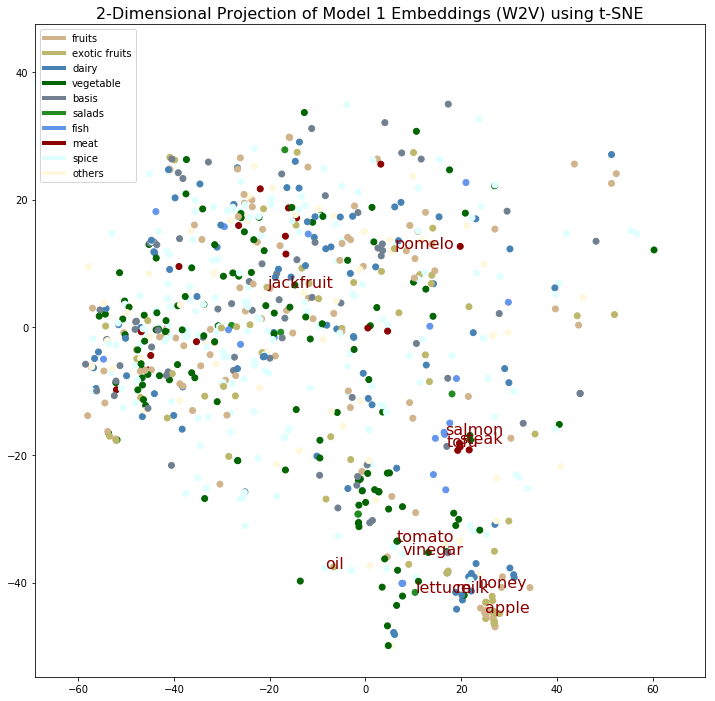

In [117]:
from matplotlib.lines import Line2D
from matplotlib import cm

fig, ax = plt.subplots(figsize=(12, 12))
plt.gca().set_title('2-Dimensional Projection of Model 1 Embeddings (W2V) using t-SNE', fontsize=16)
                       
fruits = ['Orange', 'Plum', 'Lemon', 'Apple', 'Peach', 'Mandarin', 'Strawberry', 'Cherry', 'Apricot', 'Blueberries',
         'Raspberry', 'Pear', 'Nectarine', 'Clementine']
exotic_fruits = ['Pitahaya', 'Quince', 'Pomegranate', 'Rambutan', 
                'Pomelo', 'Cantaloupe', 'Pineapple', 'Grapefruit', 'Cactus',
                'Maracuja', 'Granadilla', 'Mangostan', 'Guava', 'Passion', 'Kiwi',
                'Watermelon', 'Banana', 'Physalis', 'Kumquats', 'Huckleberry', 'Grape', 'Melon',
                'Jackfruit', 'Lychee', 'Papaya', 'Carambula', 'Star', 'Mango', 'Kaki']
dairy = ['Yoghurt', 'Milk', 'Cream', 'Egg']
vegetable = ['Romanesco', 'Mushroom', 'Eggplant', 'Bok', 'Choi', 'Tomato', 'Asparagus', 
             'Leek', 'Pumpkin', 'Corn', 'Kohlrabi','Artichoke','Cauliflower', 'Tamarillo', 'Onion',
            'Bell', 'Pepper', 'Redcurrant', 'Celery', 'Avocado', 'Pepino', 'Zucchini', 'Beetroot', 'Carrots']
basis = ['Rice', 'Pasta', 'Flour', 'Beans', 'Bulgur', 'Tofu', 'Potato']
salads = ['Cabbage', 'Cucumber', 'Kale', 'Lettuce']
fish = ['Clam', 'Tuna', 'Salmon', 'Swordfish', 'Halibut', 'Crab', 'Brass', 'Shrimp']
meat = ['Steak', 'Pork', 'Chicken', 'Turkey']
spice = ['Vinegar', 'Honey', 'Pesto', 'Sugar', 'Tahini', 'Garlic', 'Lime', 'Oil', 'Ginger_Root']
others = ['Walnut', 'Dates', 'Mulberry', 'Cocos', 'Flax', 'Hazelnut', 'Pecan', 'Goji_Berry', 'Brie', 'Coffee', 'Cheese',
         'Chestnut', 'Olives']

fruits = [i.lower() for i in fruits]
exotic_fruits = [i.lower() for i in exotic_fruits]
dairy = [i.lower() for i in dairy]
vegetable = [i.lower() for i in vegetable]
basis = [i.lower() for i in basis]
salads = [i.lower() for i in salads]
fish = [i.lower() for i in fish]
meat = [i.lower() for i in meat]
spice = [i.lower() for i in spice]
others = [i.lower() for i in others]


col = list()

for l in label_pca:
    if any([i in l for i in fruits]):
        col += ['tan']
    elif any([i in l for i in exotic_fruits]):
        col += ['darkkhaki']
    elif any([i in l for i in dairy]):
        col += ['steelblue']
    elif any([i in l for i in vegetable]):
        col += ['darkgreen']
    elif any([i in l for i in basis]):
        col += ['slategray']
    elif any([i in l for i in salads]):
        col += ['forestgreen']
    elif any([i in l for i in fish]):
        col += ['cornflowerblue']
    elif any([i in l for i in meat]):
        col += ['darkred']
    elif any([i in l for i in spice]):
        col += ['lightcyan']
    elif any([i in l for i in others]):
        col += ['cornsilk']
    else:
        col += ['None']
    

ax.scatter(x_vals, y_vals, c=col)

selected = ['apple', 'pomelo', 'jackfruit', 'milk', 'steak', 'tomato', 'lettuce', 'salmon', 
            'vinegar', 'oil', 'honey', 'tofu']

indices = [np.where(label_pca == i)[0][0] for i in selected]
for i in indices:
    ax.annotate(label_pca[i], (x_vals[i], y_vals[i]),fontsize=16, color='darkred')
    
custom_lines = [Line2D([0], [0], color='tan', lw=4),
                Line2D([0], [0], color='darkkhaki', lw=4),
                Line2D([0], [0], color='steelblue', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='slategray', lw=4),
                Line2D([0], [0], color='forestgreen', lw=4),
                Line2D([0], [0], color='cornflowerblue', lw=4),
                Line2D([0], [0], color='darkred', lw=4),
                Line2D([0], [0], color='lightcyan', lw=4),
                Line2D([0], [0], color='cornsilk', lw=4)]
                

ax.legend(custom_lines, ['fruits', 'exotic fruits', 'dairy', 'vegetable', 
                         'basis', 'salads', 'fish', 'meat', 'spice', 'others'])

fig.savefig('w2v_ingredients_embeddings.png') 

## Preparing own Vocabulary

In [33]:
class Vocabulary(object):

    START_TOKEN = u"<s>"
    END_TOKEN   = u"</s>"
    UNK_TOKEN   = u"<unk>"
    PAD_TOKEN   = u"<pad>"

    def __init__(self, tokens, size=None,
                 progressbar=lambda l:l):
        """Create a Vocabulary object.
        Args:
            tokens: iterator( string )
            size: None for unlimited, or int > 0 for a fixed-size vocab.
                  Vocabulary size includes special tokens <s>, </s>, and <unk>
            progressbar: (optional) progress bar to wrap iterator.
        """
        self.unigram_counts = Counter()
        self.bigram_counts = defaultdict(lambda: Counter())
        prev_word = None
        for word in progressbar(tokens):  # Make a single pass through tokens
            self.unigram_counts[word] += 1
            self.bigram_counts[prev_word][word] += 1
            prev_word = word
        self.bigram_counts.default_factory = None  # make into a normal dict

        # Leave space for "<s>", "</s>", <pad> and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 4))
        vocab = ([self.PAD_TOKEN, self.UNK_TOKEN, self.START_TOKEN, self.END_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    @property
    def num_unigrams(self):
        return len(self.unigram_counts)

    @property
    def num_bigrams(self):
        return len(self.bigram_counts)

    def __contains__(self, key):
        if isinstance(key, int):
            return (key > 0 and key < self.size)
        else:
            return key in self.word_to_id

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def pad_sentence(self, words, use_eos=True):
        ret = [self.START_TOKEN] + words
        if use_eos:
            ret.append(self.END_TOKEN)
        return ret

    def sentence_to_ids(self, words, use_eos=True):
        return self.words_to_ids(self.pad_sentence(words, use_eos))

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))

    def write_flat_file(self, filename):
        """Write the vocabulary list to a flat file."""
        ordered_words = self.ids_to_words(range(self.size))
        with open(filename, 'w') as fd:
            for word in ordered_words:
                fd.write(word + "\n")
        print("Vocabulary ({:,} words) written to '{:s}'".format(len(ordered_words),
                                                               filename))

    def write_projector_config(self, checkpoint_dir, tensor_name):
        """Write metadata for TensorBoard Embeddings Projector."""
        import os
        if not os.path.isdir(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        metadata_file = os.path.join(checkpoint_dir, "metadata.tsv")
        self.write_flat_file(metadata_file)
        # Write projector config pb
        projector_config_file = os.path.join(checkpoint_dir,
                                             "projector_config.pbtxt")
        with open(projector_config_file, 'w') as fd:
            contents = """embeddings {
              tensor_name: "%s"
              metadata_path: "metadata.tsv"
            }""" % tensor_name
            fd.write(contents)
        print("Projector config written to {:s}".format(projector_config_file))


In [34]:
def create_vocab(processed_steps=processed_steps):
    return Vocabulary([w for l in processed_steps for w in l])

In [35]:
ingredients_vocab = create_vocab(processed_steps)

In [36]:
ingredients_vocab.num_unigrams

54410

In [37]:
ingredients_vocab.write_flat_file('ingredients-vocab.txt')

Vocabulary (54,414 words) written to 'ingredients-vocab.txt'


In [38]:
ingredients_vocab.ids_to_words(ingredients_vocab.sentence_to_ids(processed_steps[0]))

['<s>',
 'make',
 'choice',
 'proceed',
 'recipe',
 'depending',
 'size',
 'squash',
 'cut',
 'half',
 'fourths',
 'remove',
 'seeds',
 'spicy',
 'squash',
 'drizzle',
 'olive',
 'oil',
 'melted',
 'butter',
 'cut',
 'squash',
 'piece',
 'season',
 'mexican',
 'seasoning',
 'mix',
 'ii',
 'sweet',
 'squash',
 'drizzle',
 'melted',
 'honey',
 'butter',
 'grated',
 'piloncillo',
 'cut',
 'squash',
 'piece',
 'season',
 'sweet',
 'mexican',
 'spice',
 'mix',
 'bake',
 'DGDGDG',
 'degrees',
 'depending',
 'size',
 'DGDG',
 'minutes',
 'hour',
 'fork',
 'easily',
 'pierce',
 'skin',
 'careful',
 'burn',
 'squash',
 'especially',
 'opt',
 'use',
 'sugar',
 'butter',
 'feel',
 'comfortable',
 'cover',
 'squash',
 'aluminum',
 'foil',
 'first',
 'half',
 'hour',
 'give',
 'take',
 'baking',
 'desired',
 'season',
 'salt',
 '</s>']

## Own Word2Vec Model

In [39]:
def convert_to_ids(L, vocab_dict):
    """
    Convert a list of tokenized texts to word ids
    """

    ids = []
    for text in L:
        ids.append(vocab_dict.sentence_to_ids(text))
    return ids

In [40]:
ids = convert_to_ids(processed_steps, ingredients_vocab)

In [41]:
ids[:2]

[[2,
  86,
  775,
  1850,
  440,
  655,
  338,
  484,
  51,
  69,
  2526,
  32,
  274,
  1393,
  484,
  239,
  112,
  19,
  131,
  20,
  51,
  484,
  363,
  117,
  1989,
  256,
  14,
  8746,
  497,
  484,
  239,
  131,
  304,
  20,
  401,
  8264,
  51,
  484,
  363,
  117,
  497,
  1989,
  608,
  14,
  21,
  37,
  67,
  655,
  338,
  7,
  6,
  116,
  230,
  682,
  1384,
  375,
  671,
  690,
  484,
  2165,
  4815,
  114,
  25,
  20,
  1274,
  4900,
  36,
  484,
  637,
  151,
  242,
  69,
  116,
  777,
  278,
  35,
  136,
  117,
  17,
  3],
 [2,
  56,
  18,
  37,
  67,
  201,
  214,
  59,
  124,
  128,
  7,
  126,
  544,
  13,
  21,
  4,
  6,
  48,
  142,
  51,
  326,
  58,
  121,
  103,
  77,
  60,
  10,
  1153,
  87,
  326,
  701,
  191,
  46,
  29,
  38,
  64,
  12,
  299,
  326,
  29,
  106,
  2261,
  109,
  21,
  89,
  6,
  77,
  48,
  191,
  43,
  3]]

In [66]:
def one_hot_enc(word, vocab=ingredients_vocab):

    word_vec = np.zeros(len(vocab.wordset))
    word_index = vocab.words_to_ids([word])[0]-1
    word_vec[word_index] = 1
    
    return np.asarray(word_vec)

In [68]:
one_hot_enc('tomato')

array([0., 0., 0., ..., 0., 0., 0.])

In [69]:
def create_context_training_data(corpus, context=5, vocab=ingredients_vocab):
    '''
    Creating a lit of target vectors and context matrix for training of word embedding
    Source: 
    https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281'''
    
    x_train = [] # input word
    y_train = [] # output word
    
    # Cycle through each sentence in corpus
    for sentence in corpus:
        sent_len = len(sentence)
        
        # Cycle through each word in sentence
        for i, word in enumerate(sentence):
            
            # Check whether word is relevant
            if word not in tag_list:
                continue
            
            # Convert target word to one-hot
            w_target = one_hot_enc(sentence[i])
            
            # Cycle through context window
            w_context = []
            # Note: window_size 2 will have range of 5 values
            for j in range(i - context, i + context+1):
                #Check for out-of-range error
                if j != i and j <= sent_len-1 and j >= 0:
                    # Append the one-hot representation of word to w_context
                    w_context = one_hot_enc(sentence[j])
                    
                    y_train.append(w_target)
                    x_train.append(w_context)
        
    return np.asarray(y_train), np.asarray(x_train)

In [70]:
def batcher(corpus, batch_size=50, context=5, vocab=ingredients_vocab, max_num_batches = None):
    '''
       Yields training corpus in batches
    '''
    #while True:
    batch_count = 0

    while True:

        if max_num_batches != None:
            if batch_count > max_num_batches:
                break
        
        if batch_count == len(corpus):
            break

        batch_count += 1

        for i, sentences in enumerate(corpus):
            
            y_train = list()
            x_train = list()

            if i == 0:
                start = 0
            else:
                start += batch_size

                if start > len(corpus)-1:
                    break

            if start+batch_size > len(corpus)-1:
                end = len(corpus)-1
            else:
                end = start + batch_size

            # Cycle through each sentence in corpus
            for sentence in corpus[start:end]:
                sent_len = len(sentence)

                # Cycle through each word in sentence
                for i, word in enumerate(sentence):

                    # Check whether word is relevant
                    if word not in tag_list:
                        continue

                    # Convert target word to one-hot
                    w_target = one_hot_enc(sentence[i])

                    # Cycle through context window
                    w_context = []
                    # Note: window_size 2 will have range of 5 values
                    for j in range(i - context, i + context+1):
                        #Check for out-of-range error
                        if j != i and j <= sent_len-1 and j >= 0:
                            # Append the one-hot representation of word to w_context
                            w_context = one_hot_enc(sentence[j])

                            y_train.append(w_target)
                            x_train.append(w_context)

            yield np.asarray(y_train), np.asarray(x_train)


In [71]:
batch = batcher(processed_steps)

In [72]:
y, X = next(batch)
print(y.shape, X.shape)

(1211, 54414) (1211, 54414)


In [73]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [76]:
# Model

embedding_dimension = 50

x = tf.placeholder(tf.float32, shape=(None, len(ingredients_vocab.wordset)))
y_label = tf.placeholder(tf.float32, shape=(None, len(ingredients_vocab.wordset)))

W1 = tf.Variable(tf.random_uniform([len(ingredients_vocab.wordset), embedding_dimension]))
b1 = tf.Variable(tf.random_uniform([embedding_dimension]))
hidden_representation = tf.add(tf.matmul(x,W1), b1)

W2 = tf.Variable(tf.random_uniform([embedding_dimension, len(ingredients_vocab.wordset)]))
b2 = tf.Variable(tf.random_uniform([len(ingredients_vocab.wordset)]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_representation, W2), b2))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

lr = 0.01
train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy_loss)
n_iters = 5
batch_size = 100

for _ in range(n_iters):
    print('Epoch {} of {}:'.format(_, n_iters))
    print(17*'-')
    batch = batcher(processed_steps, batch_size=batch_size)
    max_batches = len(processed_steps) // batch_size + 1
    for i in range(max_batches):
        y, X = list(), list()
        y, X = next(batch)
        assert not np.any(np.isnan(X))
        assert not np.any(np.isnan(y))
        sess.run(train_step, feed_dict={x: X, y_label: y})
        if i%5 == 0:
            print('Batch {} of {}; loss: {}'.format(i, max_batches, 
                                                  sess.run(cross_entropy_loss, feed_dict={x: X, y_label: y})))
    print(17*'='+'\n')

vectors = sess.run(W1 + b1)

Epoch 0 of 5:
-----------------
Batch 0 of 2317; loss: 14.180804252624512
Batch 5 of 2317; loss: 13.833555221557617
Batch 10 of 2317; loss: 13.26605224609375
Batch 15 of 2317; loss: 12.986346244812012
Batch 20 of 2317; loss: 13.021920204162598
Batch 25 of 2317; loss: 12.839803695678711
Batch 30 of 2317; loss: 12.931622505187988
Batch 35 of 2317; loss: 12.202013969421387
Batch 40 of 2317; loss: 12.080272674560547
Batch 45 of 2317; loss: 12.063759803771973
Batch 50 of 2317; loss: 11.190985679626465
Batch 55 of 2317; loss: 11.372066497802734
Batch 60 of 2317; loss: 10.97081184387207
Batch 65 of 2317; loss: 10.12045955657959
Batch 70 of 2317; loss: 9.681632995605469
Batch 75 of 2317; loss: 9.418205261230469
Batch 80 of 2317; loss: 10.227242469787598
Batch 85 of 2317; loss: 10.805328369140625
Batch 90 of 2317; loss: 10.447271347045898
Batch 95 of 2317; loss: 10.596654891967773
Batch 100 of 2317; loss: 10.348098754882812
Batch 105 of 2317; loss: 9.327467918395996
Batch 110 of 2317; loss: 10.

Batch 950 of 2317; loss: 3.9432663917541504
Batch 955 of 2317; loss: 4.535944938659668
Batch 960 of 2317; loss: 4.41453742980957
Batch 965 of 2317; loss: 3.968494415283203
Batch 970 of 2317; loss: 4.305610179901123
Batch 975 of 2317; loss: 4.363563537597656
Batch 980 of 2317; loss: 4.8629608154296875
Batch 985 of 2317; loss: 4.123274326324463
Batch 990 of 2317; loss: 4.98090934753418
Batch 995 of 2317; loss: 5.047640323638916
Batch 1000 of 2317; loss: 4.90761137008667
Batch 1005 of 2317; loss: 4.201385974884033
Batch 1010 of 2317; loss: 4.132901191711426
Batch 1015 of 2317; loss: 3.640277147293091
Batch 1020 of 2317; loss: 4.139586448669434
Batch 1025 of 2317; loss: 4.829922199249268
Batch 1030 of 2317; loss: 4.6209259033203125
Batch 1035 of 2317; loss: 5.785061836242676
Batch 1040 of 2317; loss: 4.342616558074951
Batch 1045 of 2317; loss: 4.505115032196045
Batch 1050 of 2317; loss: 4.053296089172363
Batch 1055 of 2317; loss: 4.8573384284973145
Batch 1060 of 2317; loss: 4.6777644157409

Batch 1880 of 2317; loss: 3.6338894367218018
Batch 1885 of 2317; loss: 3.940866470336914
Batch 1890 of 2317; loss: 3.8165383338928223
Batch 1895 of 2317; loss: 4.444016933441162
Batch 1900 of 2317; loss: 3.9269683361053467
Batch 1905 of 2317; loss: 3.4989449977874756
Batch 1910 of 2317; loss: 3.4065563678741455
Batch 1915 of 2317; loss: 3.3635804653167725
Batch 1920 of 2317; loss: 3.9156908988952637
Batch 1925 of 2317; loss: 3.9208459854125977
Batch 1930 of 2317; loss: 3.882767677307129
Batch 1935 of 2317; loss: 3.5404882431030273
Batch 1940 of 2317; loss: 3.1995983123779297
Batch 1945 of 2317; loss: 4.266966819763184
Batch 1950 of 2317; loss: 3.8686206340789795
Batch 1955 of 2317; loss: 3.835116147994995
Batch 1960 of 2317; loss: 3.85760498046875
Batch 1965 of 2317; loss: 3.3648529052734375
Batch 1970 of 2317; loss: 4.327971458435059
Batch 1975 of 2317; loss: 3.5602171421051025
Batch 1980 of 2317; loss: 3.3849387168884277
Batch 1985 of 2317; loss: 4.133277893066406
Batch 1990 of 2317;

Batch 490 of 2317; loss: 3.7090229988098145
Batch 495 of 2317; loss: 3.484400749206543
Batch 500 of 2317; loss: 3.015528678894043
Batch 505 of 2317; loss: 3.1072707176208496
Batch 510 of 2317; loss: 2.7763357162475586
Batch 515 of 2317; loss: 3.8104636669158936
Batch 520 of 2317; loss: 3.685701370239258
Batch 525 of 2317; loss: 4.200129985809326
Batch 530 of 2317; loss: 3.5750811100006104
Batch 535 of 2317; loss: 3.2557826042175293
Batch 540 of 2317; loss: 2.2529618740081787
Batch 545 of 2317; loss: 4.980092525482178
Batch 550 of 2317; loss: 3.8219733238220215
Batch 555 of 2317; loss: 3.5467679500579834
Batch 560 of 2317; loss: 3.4388697147369385
Batch 565 of 2317; loss: 5.087530136108398
Batch 570 of 2317; loss: 3.879145383834839
Batch 575 of 2317; loss: 3.9840500354766846
Batch 580 of 2317; loss: 3.893663167953491
Batch 585 of 2317; loss: 3.823824644088745
Batch 590 of 2317; loss: 3.2107162475585938
Batch 595 of 2317; loss: 3.8583154678344727
Batch 600 of 2317; loss: 3.69632887840271

Batch 1425 of 2317; loss: 3.435610055923462
Batch 1430 of 2317; loss: 3.381342649459839
Batch 1435 of 2317; loss: 3.559065818786621
Batch 1440 of 2317; loss: 3.2123260498046875
Batch 1445 of 2317; loss: 3.218963146209717
Batch 1450 of 2317; loss: 3.7058117389678955
Batch 1455 of 2317; loss: 2.998709201812744
Batch 1460 of 2317; loss: 3.6074206829071045
Batch 1465 of 2317; loss: 3.393177032470703
Batch 1470 of 2317; loss: 3.1274356842041016
Batch 1475 of 2317; loss: 3.3716516494750977
Batch 1480 of 2317; loss: 3.1571238040924072
Batch 1485 of 2317; loss: 3.837254762649536
Batch 1490 of 2317; loss: 3.2295079231262207
Batch 1495 of 2317; loss: 3.1400763988494873
Batch 1500 of 2317; loss: 3.611530303955078
Batch 1505 of 2317; loss: 3.600397825241089
Batch 1510 of 2317; loss: 3.3484303951263428
Batch 1515 of 2317; loss: 3.5842370986938477
Batch 1520 of 2317; loss: 3.2376174926757812
Batch 1525 of 2317; loss: 6.083852291107178
Batch 1530 of 2317; loss: 3.190861225128174
Batch 1535 of 2317; l

Batch 25 of 2317; loss: 3.369364023208618
Batch 30 of 2317; loss: 3.553366184234619
Batch 35 of 2317; loss: 3.2318801879882812
Batch 40 of 2317; loss: 3.337049722671509
Batch 45 of 2317; loss: 3.51313853263855
Batch 50 of 2317; loss: 3.132641315460205
Batch 55 of 2317; loss: 3.322840690612793
Batch 60 of 2317; loss: 3.9844727516174316
Batch 65 of 2317; loss: 3.0956099033355713
Batch 70 of 2317; loss: 2.9082484245300293
Batch 75 of 2317; loss: 2.995079278945923
Batch 80 of 2317; loss: 4.649693965911865
Batch 85 of 2317; loss: 3.8145017623901367
Batch 90 of 2317; loss: 3.313093900680542
Batch 95 of 2317; loss: 3.4684009552001953
Batch 100 of 2317; loss: 3.279224395751953
Batch 105 of 2317; loss: 3.479787826538086
Batch 110 of 2317; loss: 4.044066429138184
Batch 115 of 2317; loss: 3.3655500411987305
Batch 120 of 2317; loss: 3.6595935821533203
Batch 125 of 2317; loss: 3.6981863975524902
Batch 130 of 2317; loss: 3.4577581882476807
Batch 135 of 2317; loss: 3.649454116821289
Batch 140 of 2317

Batch 970 of 2317; loss: 3.3281655311584473
Batch 975 of 2317; loss: 3.402937173843384
Batch 980 of 2317; loss: 3.708902597427368
Batch 985 of 2317; loss: 3.090489625930786
Batch 990 of 2317; loss: 3.466329336166382
Batch 995 of 2317; loss: 3.6928160190582275
Batch 1000 of 2317; loss: 3.385709047317505
Batch 1005 of 2317; loss: 3.2655439376831055
Batch 1010 of 2317; loss: 3.210407257080078
Batch 1015 of 2317; loss: 3.1042490005493164
Batch 1020 of 2317; loss: 3.2565340995788574
Batch 1025 of 2317; loss: 3.6815404891967773
Batch 1030 of 2317; loss: 4.1689276695251465
Batch 1035 of 2317; loss: 4.374852180480957
Batch 1040 of 2317; loss: 3.329007148742676
Batch 1045 of 2317; loss: 3.510303497314453
Batch 1050 of 2317; loss: 3.2410671710968018
Batch 1055 of 2317; loss: 3.7647998332977295
Batch 1060 of 2317; loss: 3.8761961460113525
Batch 1065 of 2317; loss: 3.1696550846099854
Batch 1070 of 2317; loss: 3.505167007446289
Batch 1075 of 2317; loss: 3.735653877258301
Batch 1080 of 2317; loss: 3

Batch 1895 of 2317; loss: 3.7323267459869385
Batch 1900 of 2317; loss: 3.438121795654297
Batch 1905 of 2317; loss: 3.1608221530914307
Batch 1910 of 2317; loss: 3.1100027561187744
Batch 1915 of 2317; loss: 2.9713406562805176
Batch 1920 of 2317; loss: 3.413287401199341
Batch 1925 of 2317; loss: 3.489748239517212
Batch 1930 of 2317; loss: 3.373490333557129
Batch 1935 of 2317; loss: 3.047276496887207
Batch 1940 of 2317; loss: 2.8999147415161133
Batch 1945 of 2317; loss: 3.6874661445617676
Batch 1950 of 2317; loss: 3.447467803955078
Batch 1955 of 2317; loss: 3.3568756580352783
Batch 1960 of 2317; loss: 3.545130729675293
Batch 1965 of 2317; loss: 3.199317216873169
Batch 1970 of 2317; loss: 3.639190673828125
Batch 1975 of 2317; loss: 3.138577461242676
Batch 1980 of 2317; loss: 3.0371358394622803
Batch 1985 of 2317; loss: 3.5621888637542725
Batch 1990 of 2317; loss: 3.577707529067993
Batch 1995 of 2317; loss: 3.578981399536133
Batch 2000 of 2317; loss: 3.0665581226348877
Batch 2005 of 2317; lo

Batch 505 of 2317; loss: 2.8997249603271484
Batch 510 of 2317; loss: 2.534467935562134
Batch 515 of 2317; loss: 3.1585686206817627
Batch 520 of 2317; loss: 2.902143716812134
Batch 525 of 2317; loss: 3.843184471130371
Batch 530 of 2317; loss: 3.328932285308838
Batch 535 of 2317; loss: 2.84993052482605
Batch 540 of 2317; loss: 2.1302812099456787
Batch 545 of 2317; loss: 4.5898613929748535
Batch 550 of 2317; loss: 3.6593658924102783
Batch 555 of 2317; loss: 3.323645830154419
Batch 560 of 2317; loss: 3.2733561992645264
Batch 565 of 2317; loss: 4.638336658477783
Batch 570 of 2317; loss: 3.6023993492126465
Batch 575 of 2317; loss: 3.705291986465454
Batch 580 of 2317; loss: 3.6223111152648926
Batch 585 of 2317; loss: 3.6805920600891113
Batch 590 of 2317; loss: 3.078821897506714
Batch 595 of 2317; loss: 3.6048734188079834
Batch 600 of 2317; loss: 3.5037319660186768
Batch 605 of 2317; loss: 3.4444639682769775
Batch 610 of 2317; loss: 2.97463321685791
Batch 615 of 2317; loss: 2.748830795288086
B

Batch 1440 of 2317; loss: 3.009269952774048
Batch 1445 of 2317; loss: 3.1047627925872803
Batch 1450 of 2317; loss: 3.572770595550537
Batch 1455 of 2317; loss: 2.856548309326172
Batch 1460 of 2317; loss: 3.177255153656006
Batch 1465 of 2317; loss: 3.256685972213745
Batch 1470 of 2317; loss: 2.9148061275482178
Batch 1475 of 2317; loss: 3.2101070880889893
Batch 1480 of 2317; loss: 3.0450172424316406
Batch 1485 of 2317; loss: 3.637929677963257
Batch 1490 of 2317; loss: 3.1202034950256348
Batch 1495 of 2317; loss: 2.989891290664673
Batch 1500 of 2317; loss: 3.5566675662994385
Batch 1505 of 2317; loss: 3.4964678287506104
Batch 1510 of 2317; loss: 3.2299306392669678
Batch 1515 of 2317; loss: 3.466355323791504
Batch 1520 of 2317; loss: 3.1274025440216064
Batch 1525 of 2317; loss: 5.845386028289795
Batch 1530 of 2317; loss: 3.0340449810028076
Batch 1535 of 2317; loss: 2.9745664596557617
Batch 1540 of 2317; loss: 2.794776439666748
Batch 1545 of 2317; loss: 3.482689619064331
Batch 1550 of 2317; l

Batch 40 of 2317; loss: 3.203372001647949
Batch 45 of 2317; loss: 3.3885397911071777
Batch 50 of 2317; loss: 3.0394606590270996
Batch 55 of 2317; loss: 3.1764564514160156
Batch 60 of 2317; loss: 3.7852120399475098
Batch 65 of 2317; loss: 2.914290428161621
Batch 70 of 2317; loss: 2.7653143405914307
Batch 75 of 2317; loss: 2.841472864151001
Batch 80 of 2317; loss: 3.9475905895233154
Batch 85 of 2317; loss: 3.6823415756225586
Batch 90 of 2317; loss: 3.2183797359466553
Batch 95 of 2317; loss: 3.4011623859405518
Batch 100 of 2317; loss: 3.161499500274658
Batch 105 of 2317; loss: 3.408277988433838
Batch 110 of 2317; loss: 3.9030280113220215
Batch 115 of 2317; loss: 3.241895914077759
Batch 120 of 2317; loss: 3.4087326526641846
Batch 125 of 2317; loss: 3.4484455585479736
Batch 130 of 2317; loss: 3.365999937057495
Batch 135 of 2317; loss: 3.5079963207244873
Batch 140 of 2317; loss: 3.5210273265838623
Batch 145 of 2317; loss: 3.082893133163452
Batch 150 of 2317; loss: 3.0042850971221924
Batch 15

Batch 985 of 2317; loss: 3.013784170150757
Batch 990 of 2317; loss: 3.385096788406372
Batch 995 of 2317; loss: 3.602910280227661
Batch 1000 of 2317; loss: 3.3337790966033936
Batch 1005 of 2317; loss: 3.1804471015930176
Batch 1010 of 2317; loss: 3.1360528469085693
Batch 1015 of 2317; loss: 3.0339999198913574
Batch 1020 of 2317; loss: 3.2145769596099854
Batch 1025 of 2317; loss: 3.5429880619049072
Batch 1030 of 2317; loss: 4.042572021484375
Batch 1035 of 2317; loss: 4.010051250457764
Batch 1040 of 2317; loss: 3.2435359954833984
Batch 1045 of 2317; loss: 3.3716540336608887
Batch 1050 of 2317; loss: 3.1431901454925537
Batch 1055 of 2317; loss: 3.647359848022461
Batch 1060 of 2317; loss: 3.644779682159424
Batch 1065 of 2317; loss: 3.093029499053955
Batch 1070 of 2317; loss: 3.426130533218384
Batch 1075 of 2317; loss: 3.584981679916382
Batch 1080 of 2317; loss: 3.1240222454071045
Batch 1085 of 2317; loss: 3.6629128456115723
Batch 1090 of 2317; loss: 3.1935322284698486
Batch 1095 of 2317; los

Batch 1910 of 2317; loss: 3.0235650539398193
Batch 1915 of 2317; loss: 2.896740198135376
Batch 1920 of 2317; loss: 3.3073346614837646
Batch 1925 of 2317; loss: 3.344508171081543
Batch 1930 of 2317; loss: 3.3309195041656494
Batch 1935 of 2317; loss: 2.9702818393707275
Batch 1940 of 2317; loss: 2.8563268184661865
Batch 1945 of 2317; loss: 3.4952902793884277
Batch 1950 of 2317; loss: 3.3315670490264893
Batch 1955 of 2317; loss: 3.241607666015625
Batch 1960 of 2317; loss: 3.459289073944092
Batch 1965 of 2317; loss: 3.139599323272705
Batch 1970 of 2317; loss: 3.5081686973571777
Batch 1975 of 2317; loss: 3.072117567062378
Batch 1980 of 2317; loss: 2.974595308303833
Batch 1985 of 2317; loss: 3.4154255390167236
Batch 1990 of 2317; loss: 3.4977831840515137
Batch 1995 of 2317; loss: 3.474893808364868
Batch 2000 of 2317; loss: 3.0199639797210693
Batch 2005 of 2317; loss: 3.649195432662964
Batch 2010 of 2317; loss: 3.4073288440704346
Batch 2015 of 2317; loss: 3.500314950942993
Batch 2020 of 2317; 

In [77]:
vectors

array([[0.7382465 , 1.6406057 , 1.1376666 , ..., 0.66619027, 1.2648009 ,
        0.8295408 ],
       [1.383379  , 1.5244789 , 0.91512394, ..., 0.412701  , 1.5009865 ,
        1.4333427 ],
       [0.9304072 , 1.6459173 , 1.2647636 , ..., 0.48848367, 1.1953665 ,
        0.50723547],
       ...,
       [1.3366368 , 1.1325439 , 1.4066998 , ..., 0.46408498, 1.0649492 ,
        1.2342472 ],
       [0.93151337, 1.8251752 , 0.75149834, ..., 0.18189631, 1.1778609 ,
        1.1008546 ],
       [0.80922467, 1.0087272 , 0.990288  , ..., 0.49163747, 1.29847   ,
        1.2120111 ]], dtype=float32)

In [82]:
filename = 'own_embedding_vectors.txt.gz'
np.savetxt(filename, vectors)

In [83]:
vectors = np.loadtxt(filename)

In [84]:
vectors

array([[0.7382465 , 1.64060569, 1.13766658, ..., 0.66619027, 1.26480091,
        0.82954079],
       [1.38337898, 1.52447891, 0.91512394, ..., 0.41270101, 1.50098646,
        1.4333427 ],
       [0.93040723, 1.6459173 , 1.26476359, ..., 0.48848367, 1.1953665 ,
        0.50723547],
       ...,
       [1.33663678, 1.13254392, 1.40669978, ..., 0.46408498, 1.06494915,
        1.23424721],
       [0.93151337, 1.82517517, 0.75149834, ..., 0.18189631, 1.17786086,
        1.10085464],
       [0.80922467, 1.00872719, 0.99028802, ..., 0.49163747, 1.29847002,
        1.2120111 ]])

In [85]:
len(vectors)

54414

In [86]:
len(ingredients_vocab.wordset)

54414

In [142]:
def cos_sim(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def topn_closest(word, embeddings=vectors, n=10, vocab=ingredients_vocab, dist=cos_sim):
    topn = list()
    word_index = vocab.words_to_ids([word])[0]
    query_vector = embeddings[word_index]
    
    for index, vector in enumerate(vectors):
        word_dist = dist(vector, query_vector)
        topn.append((vocab.ids_to_words([index])[0], word_dist))
    
    return sorted(topn, key=lambda x: -x[1])[:n]

In [143]:
top10 = topn_closest('tomato')

In [144]:
top10

[('tomato', 0.9999999999999999),
 ('crudities', 0.982010672634317),
 ('sumptuously', 0.9791012739444556),
 ('trinidad', 0.9786416047114124),
 ('horseradish-tomato', 0.9783019917694172),
 ('shallot-butter', 0.9781146686215447),
 ('sautcutlets', 0.9777838046665926),
 ('rounding', 0.9777547137864817),
 ('caribou', 0.9773568484738311),
 ('luv', 0.9773499317928603)]

In [164]:
# Alternative idea:

def topn_closest_ingredient(word, labels=labels, embeddings=vectors, n=10, vocab=ingredients_vocab, dist=cos_sim):
    topn = list()
    label_list = list(set([ingredient for label in labels for ingredient in label.lower().split('_')]))
    word_index = vocab.words_to_ids([word])[0]
    query_vector = embeddings[word_index]
    
    for label in label_list:
        try:
            label_index = vocab.words_to_ids([label])[0]
            comparison_vector = embeddings[label_index]
            word_dist = dist(comparison_vector, query_vector)
            topn.append((vocab.ids_to_words([label_index])[0], word_dist))
        except KeyError:
            comparison_vector = embeddings[1]
            word_dist = dist(comparison_vector, query_vector)
            topn.append((u'<unk>', word_dist))
    
    return sorted(topn, key=lambda x: -x[1])[:n]


In [167]:
top10 = topn_closest_ingredient('apple')

In [168]:
top10

[('apple', 1.0000000000000002),
 ('mango', 0.9614745850589773),
 ('lettuce', 0.9581770549693374),
 ('beetroot', 0.9571584938306279),
 ('rice', 0.9565884805455216),
 ('potato', 0.9547166922334203),
 ('kohlrabi', 0.9545867876403827),
 ('soy', 0.9537563861442201),
 ('tomato', 0.9534546537617955),
 ('jackfruit', 0.952864511410381)]

In [169]:
filename = 'model-own-embeddings-top10-similarities-labels.txt'

with open(filename, 'w') as fd:
    for label in labels:
        try:
            fd.write(label + "\n")
            sim = topn_closest_ingredient(label.lower(), n=11)
            for i in sim:
                fd.write(str(i) + "\n")
            fd.write(17*'-' + "\n")
        except KeyError:
            continue
    
print("Top 10 similarities over labels based on own model writen to file")

Top 10 similarities over labels based on own model writen to file
